In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time

In [2]:
## Step 1: Load and Preprocess Datas
# Define transformations for images
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [3]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=False)

In [4]:
# Get the shape of the first image in the training dataset
image, label = train_dataset[0]
print("Image shape:", image.shape)
print("Number of training samples:", len(train_dataset))

Image shape: torch.Size([1, 28, 28])
Number of training samples: 60000


In [5]:
# Get the shape of the first image in the test dataset
image, label = test_dataset[0]
print("Image shape:", image.shape)
print("Number of testing samples:", len(test_dataset))

Image shape: torch.Size([1, 28, 28])
Number of testing samples: 10000


In [6]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=2, pin_memory=True)


In [7]:
class CNNClassifier(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.conv1    = nn.Conv2d(1, 32, kernel_size=3, stride = 1, padding=1)  # 32x28x28
        self.r1       = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2,2) # 32x14x14

        self.conv2    = nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding=1) # 64x14x14
        self.r2       = nn.ReLU()
        self.maxpool2  = nn.MaxPool2d(2,2) # 64x7x7

        self.l1       = nn.Linear(64 * 7 * 7, 128)
        self.r3       = nn.ReLU()
        self.l2       = nn.Linear(128,10)

    def forward(self, x):
        x = self.maxpool1(self.r1(self.conv1(x)))
        x = self.maxpool2(self.r2(self.conv2(x)))
     
        x = x.view(x.size(0), -1) # Flatten the conv output to 1D tensor 

        x = self.r3(self.l1(x))
        x = self.l2(x)

        return x

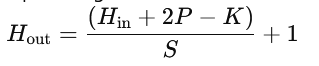

In [ ]:
from torchsummary import summary

# Initialize model
model = CNNClassifier()

# Move model to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)

# Print model summary
print('Name: Sanjay Sivaramakrishnan M')
print('Register Number: 212223240151')
print("Model moved to CUDA : ",next(model.parameters()).is_cuda)
summary(model, input_size=(1, 28, 28))

Name: Sanjay Sivaramakrishnan M
Register Number: 212223240151
Model moved to CUDA :  True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params s

In [9]:
# Initialize loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
import time
from tqdm import tqdm

def train_model(model, train_loader, num_epochs=3):
    for epoch in range(num_epochs):
        start_epoch = time.time()
        running_loss = 0.0

        # Wrap loader with tqdm
        tqdm_trainloader = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]", unit="batch")

        for i, (images, labels) in enumerate(tqdm_trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * images.size(0)

            # Update tqdm postfix (average loss so far)
            tqdm_trainloader.set_postfix(loss=f"{running_loss / ((i+1)*images.size(0)):.4f}")

        torch.cuda.synchronize()
        end_epoch = time.time()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Loss: {epoch_loss:.4f}, Time: {end_epoch - start_epoch:.2f}s")


In [11]:
# Train the model
train_model(model, train_loader, num_epochs=10)

Epoch [1/10]: 100%|██████████| 1875/1875 [00:43<00:00, 43.40batch/s, loss=0.1209] 


Epoch [1/10] completed. Loss: 0.1209, Time: 43.22s


Epoch [2/10]: 100%|██████████| 1875/1875 [00:27<00:00, 68.32batch/s, loss=0.0405] 


Epoch [2/10] completed. Loss: 0.0405, Time: 27.44s


Epoch [3/10]: 100%|██████████| 1875/1875 [00:35<00:00, 53.48batch/s, loss=0.0272]


Epoch [3/10] completed. Loss: 0.0272, Time: 35.07s


Epoch [4/10]: 100%|██████████| 1875/1875 [00:33<00:00, 56.65batch/s, loss=0.0193] 


Epoch [4/10] completed. Loss: 0.0193, Time: 33.10s


Epoch [5/10]: 100%|██████████| 1875/1875 [01:45<00:00, 17.79batch/s, loss=0.0145]


Epoch [5/10] completed. Loss: 0.0145, Time: 105.43s


Epoch [6/10]: 100%|██████████| 1875/1875 [01:41<00:00, 18.54batch/s, loss=0.0118]


Epoch [6/10] completed. Loss: 0.0118, Time: 101.16s


Epoch [7/10]: 100%|██████████| 1875/1875 [01:45<00:00, 17.84batch/s, loss=0.0107]


Epoch [7/10] completed. Loss: 0.0107, Time: 105.08s


Epoch [8/10]: 100%|██████████| 1875/1875 [01:54<00:00, 16.43batch/s, loss=0.0077] 


Epoch [8/10] completed. Loss: 0.0077, Time: 114.11s


Epoch [9/10]: 100%|██████████| 1875/1875 [01:05<00:00, 28.57batch/s, loss=0.0074]


Epoch [9/10] completed. Loss: 0.0074, Time: 65.62s


Epoch [10/10]: 100%|██████████| 1875/1875 [01:52<00:00, 16.68batch/s, loss=0.0065]

Epoch [10/10] completed. Loss: 0.0065, Time: 112.40s


In [12]:
## Step 4: Test the Model

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    # Print classification report
    print('Name: Sanjay Sivaramakrishnan M')
    print('Register Number: 212223240151')
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

Test Accuracy: 0.9902


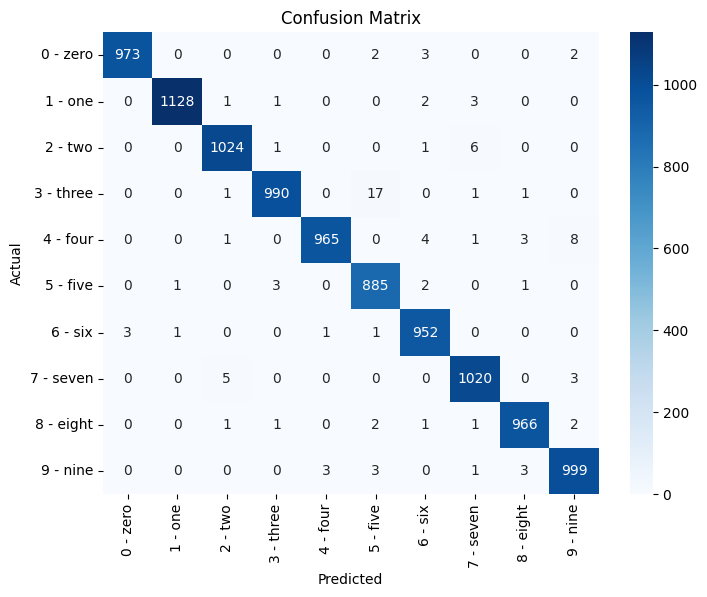

Name: Sanjay Sivaramakrishnan M
Register Number: 212223240151
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [13]:
# Evaluate the model
test_model(model, test_loader)


In [16]:
## Step 5: Predict on a Single Image
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    if torch.cuda.is_available():
        image = image.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    class_names = [str(i) for i in range(10)]

    print('Name: Sanjay Sivaramakrishnan M')
    print('Register Number: 212223240151')
    plt.imshow(image.cpu().squeeze(), cmap="gray")
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()
    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}')

Name: Sanjay Sivaramakrishnan M
Register Number: 212223240151


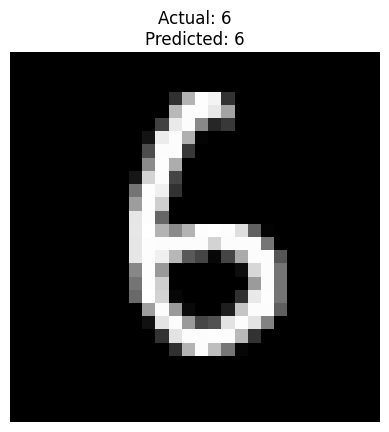

Actual: 6, Predicted: 6


In [19]:
# Example Prediction
predict_image(model, image_index=21, dataset=test_dataset)